# Challenge Set 1
#Topic:        Explore MTA turnstile data
#Date:         04/18/2016
#Name:         Cecilia
#Worked with:  Hannah, Ajit, Zakkir

# Challenges 1-3 Using Dictionaries

In [1]:
from __future__ import division
import csv
from datetime import datetime
from collections import Counter

In [2]:
with open('turnstile_160305.txt') as f: 
    reader = csv.reader(f) 
    rows = [[cell.strip() for cell in row] for row in reader]

In [3]:
assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                       'EXITS'] 

In [4]:
#Challenge 1
raw_readings = {}    
for row in rows:    
    raw_readings.setdefault(tuple(row[:4]), []).append(tuple(row[4:])) 

In [5]:
#Challenge 2
datetime_cumulative = {turnstile: [(datetime.strptime(date + time,'%m/%d/%Y%X'),int(in_cumulative))
                                   for _, _, date, time,_, in_cumulative, _ in rows]
                       for turnstile, rows in raw_readings.items()}    

In [6]:
#Challenge 3
datetime_count_times = {turnstile: [[rows[i][0],
                                     rows[i+1][1] - rows[i][1],
                                     rows[i+1][0] - rows[i][0]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative.items()}

In [7]:
datetime_counts = {turnstile: [(time, count)
                               for (time, count, _) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in datetime_count_times.items()} 

# Challenges 3-10 Using Pandas

In [8]:
import pandas as pd
import numpy as np

In [9]:
dataset = ["turnstile_160402.txt", "turnstile_160326.txt", "turnstile_160319.txt", 
           "turnstile_160312.txt", "turnstile_160305.txt"]

data = pd.DataFrame()
dfList = []

for datafile in dataset:
    df = pd.read_csv(datafile)
    dfList.append(df)
    
data = pd.concat(dfList) #Read CSV's

In [10]:
#data = pd.read_csv('turnstile_160305.txt')

In [11]:
#data[0:5]

In [12]:
#Set up key, convert datetime to operable form, add column with differences, clean and remove 
#negative values and outliers and mistakened values due to MTA collection error
data['DateTime'] = data['DATE'] + " " + data['TIME']
data['DateTime'] = pd.to_datetime(data['DateTime'])
data['DATE'] = pd.to_datetime(data['DATE'])
data['KEY'] = data['C/A']+","+data['UNIT']+","+data['SCP']+","+data['STATION']
data = data.sort_values(['KEY','DateTime']).groupby('KEY').head(100000000000)
#data['EntriesDifference'] = data.groupby('KEY')['ENTRIES'].transform(pd.Series.diff)
data['EntriesDifference'] = data.groupby('KEY')['ENTRIES'].diff()
data = data[data.EntriesDifference >=0]
data = data[data.EntriesDifference <=1000000]

data[0:5]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DateTime,KEY,EntriesDifference
1,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-02-27,07:00:00,REGULAR,5562184,1877586,2016-02-27 07:00:00,"A002,R051,02-00-00,59 ST",12
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-02-27,11:00:00,REGULAR,5562267,1877691,2016-02-27 11:00:00,"A002,R051,02-00-00,59 ST",83
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-02-27,15:00:00,REGULAR,5562516,1877745,2016-02-27 15:00:00,"A002,R051,02-00-00,59 ST",249
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-02-27,19:00:00,REGULAR,5562920,1877821,2016-02-27 19:00:00,"A002,R051,02-00-00,59 ST",404
5,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-02-27,23:00:00,REGULAR,5563175,1877862,2016-02-27 23:00:00,"A002,R051,02-00-00,59 ST",255


In [13]:
#Challenge 3
#Now make it that we again have the same keys, but now we have a single value for a single day, 
#cwhich is the total number of passengers that entered through this turnstile on this day.


keybyday = data.groupby(['KEY','DATE'])['EntriesDifference'].agg(pd.np.sum)
#print set(tuple(data['KEY'][data['EntriesDifference'] < 0]))
#keybyday
#data.loc[data['KEY'] == 'A002,R051,02-00-00,59 ST']
######

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

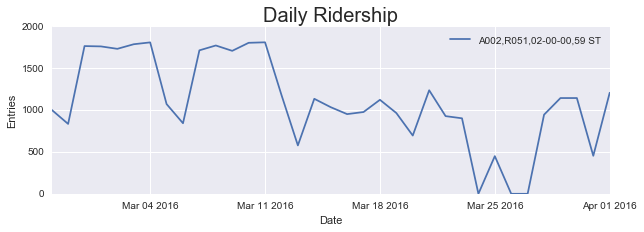

In [15]:
#Challenge 4
#We will plot the daily time series for a turnstile. This will make your matplotlib graphs 
#integrate nicely with the notebook. To plot the time series, import matplotlib with
#Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into 
#two lists: dates and counts. This should plot it:


plt.figure(figsize=(10,3))
plt.plot(keybyday['A002,R051,02-00-00,59 ST'])
plt.title("Daily Ridership",fontsize=20)
plt.xlabel('Date')
plt.ylabel('Entries')
plt.legend(['A002,R051,02-00-00,59 ST'],loc='best',prop={'size':10})
#add label

In [16]:
#Challenge 5 Set-Up
#So far we've been operating on a single turnstile level, let's combine turnstiles in the same 
#ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single 
#turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, 
#different values for the SCP column.
#We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, 
#add the counts from each turnstile belonging to that combo.


In [17]:
#Challenge 5 Set-Up
data['KEY2'] = data['C/A']+","+data['UNIT']+","+data['STATION']

In [18]:
#CHALLENGE 5 Answer

serieschallenge5 = data.groupby(['KEY2','DATE'])['EntriesDifference'].agg(pd.np.sum)
#serieschallenge5[0:1000]

In [19]:
#CHALLENGE 6
#Similarly, combine everything in each station, and come up with a time series of 
#[(date1, count1),(date2,count2),...] type of time series for each STATION, by 
#adding up all the turnstiles in a station.

stationbydate = data.groupby(['STATION','DATE'])['EntriesDifference'].agg(pd.np.sum)
#stationbydate

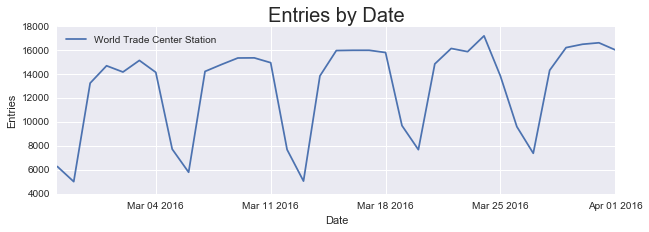

In [20]:
#Challenge 7
#Plot the time series for a station.
plt.figure(figsize=(10,3))
plt.plot(stationbydate['WORLD TRADE CTR'])
plt.title("Entries by Date",fontsize=20)
plt.xlabel('Date')
plt.ylabel('Entries')
plt.legend(['World Trade Center Station'],loc='best',prop={'size':10})

In [21]:
from pandas.tseries.offsets import Week
#Challenge 8
#Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. 
#so it's a list of 7 counts. Make the same list for another week, and another week, and another 
#week. plt.plot(week_count_list) for every week_count_list you created this way. You should get 
#a rainbow plot of weekly commute numbers on top of each other.

#Add Day of Week Col in DF and convert day number to string
#days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
data['DayOfWeek'] = data['DATE'].dt.dayofweek
#data['DayOfWeek'] = data['DayOfWeek'].apply(lambda x:days[x])

#Add Saturday Week Ending column to dataframe so it can be grouped-by
#Needs tweaking
data['SaturdayWeekEndingDate'] = data['DATE'] + Week(weekday=6)

In [22]:
stationweekday = data.groupby(['STATION','SaturdayWeekEndingDate','DayOfWeek'])['EntriesDifference'].agg(pd.np.sum)
#stationweekday.head()

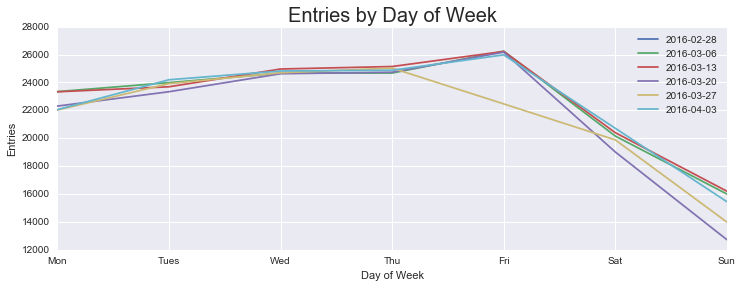

In [23]:
statweekdaydf = stationweekday.to_frame()

plt.figure(figsize=(12,4))
plt.plot(statweekdaydf['EntriesDifference']['1 AV']['2016-02-28'], label="2016-02-28")
plt.plot(statweekdaydf['EntriesDifference']['1 AV']['2016-03-06'], label="2016-03-06")
plt.plot(statweekdaydf['EntriesDifference']['1 AV']['2016-03-13'], label="2016-03-13")
plt.plot(statweekdaydf['EntriesDifference']['1 AV']['2016-03-20'], label="2016-03-20")
plt.plot(statweekdaydf['EntriesDifference']['1 AV']['2016-03-27'], label="2016-03-27")
plt.plot(statweekdaydf['EntriesDifference']['1 AV']['2016-04-03'], label="2016-04-03")
plt.title("Entries by Day of Week",fontsize=20)
plt.xlabel("Day of Week")
plt.ylabel("Entries")
plt.xticks([0,1,2,3,4,5,6],['Mon','Tues','Wed','Thu',"Fri","Sat","Sun"])
plt.legend()

In [24]:
#Challenge 9
#Over multiple weeks, sum total ridership for each station and sort them, so you can find out 
#the stations with the highest traffic during the time you investigate

#Groupby station & line name and sort largest to smallest
stationtotals = data.groupby(['STATION','LINENAME'])['EntriesDifference'].agg(pd.np.sum).sort_values(ascending=0)
#stationtotals.head()

In [25]:
df = pd.DataFrame(stationtotals)

In [26]:
#Create list with list of names for chart
namesarray = list(df.index.values[0:20])

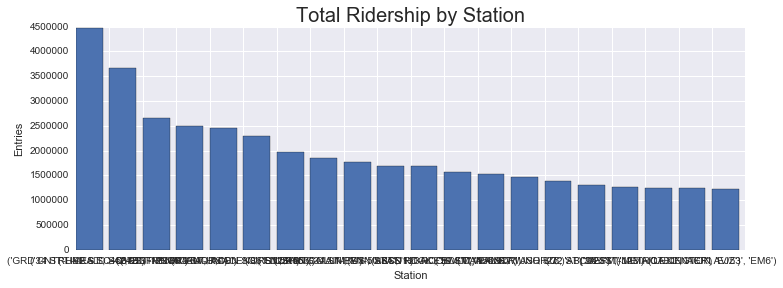

In [27]:
#Challenge 10
#Make a single list of these total ridership values and plot it 

#plt.hist(stationtotals)

#top 20 only
plt.figure(figsize=(12,4))
top20 = stationtotals[0:20]
indices = range(len(top20))

plt.bar(indices, top20, tick_label=namesarray)
plt.xlabel('Station')
plt.ylabel('Entries')
plt.title("Total Ridership by Station",fontsize=20)
#plt.xticks(fontsize=20)


In [28]:
#Identify Outliers 
#plt.scatter(data['EntriesDifference'],data['ENTRIES'])